In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def cv_show(img,name):
    cv2.imshow(name,img)
    cv2.waitKey()
    cv2.destroyAllWindows()

In [3]:
#读取卡图片
img=cv2.imread('images/credit_card_01.png')
cv_show(img,'img')


<function matplotlib.pyplot.show(close=None, block=None)>

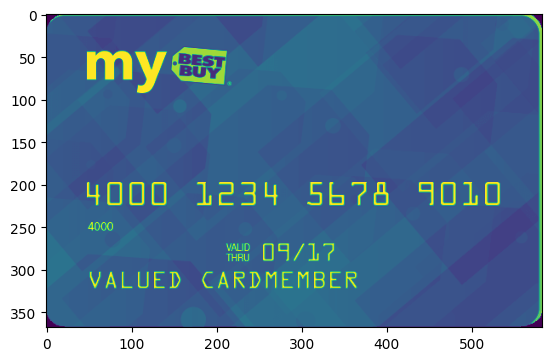

In [4]:
plt.imshow(img)
plt.show # plt的不是灰度图

In [5]:
kernel=np.ones((5,5),np.uint8)
closing=cv2.morphologyEx(img,cv2.MORPH_CLOSE,kernel)

In [6]:
cv_show(closing,'closing')

### 对模板图像进行处理

In [47]:
# 读取模板图片（灰度）
img_tem=cv2.imread('ocr_a_reference.png')
img_t_gray=cv2.cvtColor(img_tem, cv2.COLOR_BGR2GRAY)
cv_show(img_t_gray,'gray')
# 将模板二值化
img_t_thresh = cv2.threshold(img_t_gray,10,255,cv2.THRESH_BINARY_INV)[1]
cv_show(img_t_thresh,'thresh')

In [48]:
# 绘制轮廓
contours_tem, hierarchy = cv2.findContours(img_t_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img_tem, contours_tem, -1, (0,0,255), 3) #-1表示绘制出所有轮阔
cv_show(img_tem,'img_tem')

In [81]:
cnts=np.zeros((len(contours_tem),5)) #x,y,w,h,数字
for i,cnt in enumerate(contours_tem):
    cnts[i][0:4]=cv2.boundingRect(cnt) # 外接矩形的x,y,w,h
    cnts[i][4]=9-i # 因为第一个外接矩形是最左边数字的
cnts=cnts.astype('int') # 转为整数
cnts

array([[730,  20,  54,  85,   9],
       [651,  20,  53,  85,   8],
       [571,  20,  53,  85,   7],
       [492,  20,  53,  85,   6],
       [412,  20,  53,  85,   5],
       [338,  20,  48,  85,   4],
       [253,  20,  53,  85,   3],
       [174,  20,  53,  85,   2],
       [ 94,  20,  53,  85,   1],
       [ 15,  20,  53,  85,   0]])

In [82]:
# 用一个字典将对应矩形区域的图像保存
digits={}
for rect in cnts:
    [x,y,w,h,num]=rect[:]
    digits[num]=img_t_thresh[y:y+h,x:x+w]
    

In [146]:
# 展示
for digit,digit_img in digits.items():
    cv_show(digit_img,'digit')
#     print(digit_img.shape[0])
#     print(digit_img.shape[1])

85
54
85
53
85
53
85
53
85
53
85
48
85
53
85
53
85
53
85
53


### 对卡图像进行处理

In [84]:
def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    resized = cv2.resize(image, dim, interpolation=inter)
    return resized

In [99]:
# 初始化卷积核
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))  # 矩形卷积核
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  # 方形卷积核

In [92]:
#读取卡图片
img=cv2.imread('images/credit_card_01.png')
img=resize(img,width=300)
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
cv_show(gray,'gray')
# 阈值操作，保留白色的字体部分
thresh=cv2.threshold(gray,100,255,cv2.THRESH_BINARY)[1]
cv_show(thresh,'thresh')

In [103]:
# 梯度运算
sobelx = cv2.Sobel(thresh,cv2.CV_64F,1,0,ksize=3)
sobely = cv2.Sobel(thresh,cv2.CV_64F,0,1,ksize=3)
sobelx = cv2.convertScaleAbs(sobelx)   
sobely = cv2.convertScaleAbs(sobely)  
sobelxy =  cv2.addWeighted(sobelx,0.5,sobely,0.5,0)
cv_show(sobelxy,"xy")
cv_show(sobelx,'x')
cv_show(sobely,'y')

In [105]:
# 梯度运算产生了缝隙，需要填补这些缝隙，用闭运算
closing = cv2.morphologyEx(sobelx, cv2.MORPH_CLOSE, rectKernel)
cv_show(closing,'close')

In [110]:
# 画出轮廓
threshCnts, hierarchy = cv2.findContours(closing.copy(), cv2.RETR_EXTERNAL,
                                         cv2.CHAIN_APPROX_SIMPLE)
cur_img = img.copy()  # 这里的image已经缩放过了
cv2.drawContours(cur_img, threshCnts, -1, (0, 0, 255), 3)
cv_show(cur_img,'contours')

In [113]:
# 筛选出包含数字的轮廓
rects=[]
cnts=threshCnts
len(cnts) #11个轮廓
for i,cnt in enumerate(cnts):
    x,y,w,h=cv2.boundingRect(cnt)
    r=w/h # 计算宽高比
    if r<3 or r>4:
        continue
    rects.append([x,y,w,h])

# 展示外接矩形
img_rect=img.copy()
for rect in rects:
    x,y,w,h=rect[:]
    cv2.rectangle(img_rect,(x,y),(x+w,y+h),(0,0,255),2) #需要传入对角线坐标
cv_show(img_rect,'rects')

In [114]:
print(digits)

{9: array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0, 255, ..., 255,   0,   0],
       [  0, 255, 255, ..., 255, 255,   0],
       ...,
       [  0,   0,   0, ..., 255, 255,   0],
       [  0,   0,   0, ..., 255,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8), 8: array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 7: array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0, 255, ..., 255, 255, 255],
       [  0, 255, 255, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8), 6: array([[  0,   0,   0, ...,   0,   0,   0],
       [  0, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ..., 255, 255,   0]

In [156]:
# 遍历每一个符合要求得外接矩形
match_result=[]
for rect in rects:
    # 第一个是最左边的矩形
    x,y,w,h=rect[:]
    w_single=int(w/4)
    match_digits=[]
    img_rect=gray[y:y+h,x:x+w]
    img_rect=cv2.threshold(img_rect,100,255,cv2.THRESH_BINARY)[1]
    cv_show(img_rect,'rect')
    cnts,_ = cv2.findContours(img_rect.copy(), cv2.RETR_EXTERNAL,
                                         cv2.CHAIN_APPROX_SIMPLE)
    print(f'应该是4:{len(cnts)}') # 应该是4
    for cnt in cnts:
        # 第一个数字是最左边的数字
        x0,y0,w0,h0=cv2.boundingRect(cnt)
        match_img=img_rect[y0:y0+h0,x0:x0+w0]
#         cv_show(match_img,'num')
        scores={}
        re=cv2.resize(match_img,(53,85))
        for digit,digit_img in digits.items():
            digit_img=cv2.resize(digit_img,(53,85))
            result = cv2.matchTemplate(re, digit_img,
                                       cv2.TM_CCOEFF_NORMED)  # 用相关系数计算得分，越大越好
            (_, score, _, _) = cv2.minMaxLoc(result)
            scores[digit]=score
        # 寻找得分最高的那个数字
        max_val=0
        best_digit=-1
        for digit,s in scores.items():
            if s>max_val:
                best_digit=digit
                max_val=s
        match_digits.append(best_digit)
    match_digits.reverse()
    match_result.append(match_digits)    
match_result.reverse()
match_result
# [[4, 0, 0, 0], [1, 2, 3, 4], [5, 6, 7, 8], [9, 0, 1, 0]]

应该是4:4
应该是4:4
应该是4:4
应该是4:4


[[4, 0, 0, 0], [1, 2, 3, 4], [5, 6, 7, 8], [9, 0, 1, 0]]